<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/rag-with-python-cookbook/03_text_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install requirements

In [ ]:
!pip install sentence-transformers==4.1.0
!pip install requests==2.32.3
!pip install matplotlib==3.10.3
!pip install openai==1.79.0
!pip install langchain-openai==0.3.17
!pip install pandas==2.2.3
!pip install rank-bm25
!pip install langchain_text_*splitters
!pip install openai==1.83.0
!pip install PyPDF2==3.0.1


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached openai-1.79.0-py3-none-any.whl.metadata (25 kB)
Using cached openai-1.79.0-py3-none-any.whl (683 kB)
  Attempting uninstall: openai
    Found existing installation: openai 1.83.0
    Uninstalling openai-1.83.0:
      Successfully uninstalled openai-1.83.0



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: 'langchain_text_*splitters': Expected end or semicolon (after name and no valid version specifier)
    langchain_text_*splitters
                   ^


  Using cached openai-1.83.0-py3-none-any.whl.metadata (25 kB)
Using cached openai-1.83.0-py3-none-any.whl (723 kB)
  Attempting uninstall: openai
    Found existing installation: openai 1.79.0
    Uninstalling openai-1.79.0:
      Successfully uninstalled openai-1.79.0



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### How to generate embeddings using the OpenAI and HuggingFace API

In [ ]:
from openai import OpenAI

def calculate_embeddings_using_openai():
    """
    Returns:
        embeddings (list): list of embeddings
    """

    # tag::calculate_embeddings_using_openai[]
    from openai import OpenAI

    text_chunks = ["The sky is blue.", "The grass is green."]

    client = OpenAI()  # uses the environment variable OPENAI_API_KEY

    embeddings_list = []

    for text_chunk in text_chunks:
        response = client.embeddings.create(
            input=[text_chunk], model="text-embedding-3-small"
        )
        embedding = response.data[0].embedding
        embeddings_list.append(embedding)

    # end::calculate_embeddings_using_openai[]

    # tag::calculate_embeddings_using_openai_with_langchain[]
    from langchain_openai import OpenAIEmbeddings

    embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
    embeddings_langchain_list = []

    for text_chunk in text_chunks:
        embeddings_openai_langchain = embeddings.embed_query(text_chunk)
        embeddings_langchain_list.append(embeddings_openai_langchain)

    # end::calculate_embeddings_using_openai_with_langchain[]
    return embeddings_list, embeddings_langchain_list


# calculate embeddings using openai
embeddings_list, embeddings_langchain_list = (
    calculate_embeddings_using_openai()
)

In [ ]:
print(embeddings_list)
print("Length of embeddings:", len(embeddings_list[0]))

print(embeddings_langchain_list)
print("Length of embeddings:", len(embeddings_langchain_list[0]))

[[0.01542501151561737, -0.013965080492198467, -0.018416674807667732, 0.007844138890504837, 0.013737713918089867, -0.0034673367626965046, -0.004263118840754032, 0.011918783187866211, -0.03896341100335121, -0.02879175916314125, 0.013989013619720936, 0.014359979890286922, -0.004122511018067598, 0.026446295902132988, -0.01384541392326355, 0.014922412112355232, -0.014623246155679226, -0.015712210908532143, -0.005307209212332964, 0.004122511018067598, 0.0054747420363128185, -0.023813633248209953, 0.007927905768156052, 0.04197900742292404, -0.01003403589129448, 0.0033057869877666235, 0.03850867971777916, -0.0015302352840080857, -0.038436878472566605, -0.0009431215585209429, 0.03893947973847389, -0.037144482135772705, -0.017902107909321785, -0.04631093516945839, 0.03262108564376831, -0.0353255495429039, 0.036354683339595795, 0.00044538374640978873, -0.03410495072603226, -0.05207885801792145, -0.0008443967089988291, -0.050834327936172485, 0.012235899455845356, -0.022234035655856133, 8.255118154

In [ ]:

def create_text_embeddings_using_huggingface():
    '''
    Returns:
        embeddings (list): list of embeddings
    '''
    # tag::create_text_embeddings_using_huggingface[]
    from sentence_transformers import SentenceTransformer

    # Load the model
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    text_chunks = ["The sky is blue.", "The grass is green."]

    # Generate embeddings
    embeddings = model.encode(text_chunks)

    # end::create_text_embeddings_using_huggingface[]

    return embeddings

embeddings_huggingface = create_text_embeddings_using_huggingface()


c:\Users\z004j58u\repos\others\rag-oreily-book\.venv_embeddings\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
embeddings_huggingface

array([[ 1.79194771e-02,  1.35288145e-02,  4.27966937e-02,
         1.67181976e-02,  2.98237633e-02,  5.00751333e-03,
         9.92993265e-02, -2.73153894e-02,  3.44540589e-02,
         2.14895550e-02, -4.62054759e-02, -9.81956813e-03,
        -2.34511797e-03, -1.50827942e-02, -2.05804687e-02,
         1.39620155e-01, -3.65893990e-02, -9.39908475e-02,
        -7.07923323e-02, -2.75131259e-02, -7.43589774e-02,
         6.67031929e-02, -5.70849814e-02,  1.00319229e-01,
        -4.83448543e-02,  5.18621430e-02,  6.67829439e-03,
         2.90899519e-02,  3.23366821e-02,  2.60732472e-02,
        -4.50622179e-02,  8.68449435e-02,  2.29268484e-02,
         7.23596779e-04, -1.80890393e-02, -4.82870750e-02,
        -9.85104404e-03, -2.82281786e-02, -6.18578587e-03,
        -4.38690186e-03,  3.46947840e-04, -4.53426018e-02,
        -6.35197237e-02, -8.63484666e-03,  2.76453104e-02,
         1.09326653e-02, -2.73536034e-02,  6.14280142e-02,
         3.45266201e-02, -2.44225822e-02, -6.07561804e-0

In [ ]:
print(embeddings_huggingface)
print("Length of embeddings:", len(embeddings_huggingface[0]))

In [ ]:

def calculate_embeddings_using_openai():
    """
    Calculates text embeddings using both the OpenAI API and LangChain's OpenAIEmbeddings.

    Returns:
        embeddings_list (list): List of embeddings generated by the OpenAI API for each text chunk.
        embeddings_langchain_list (list): List of embeddings generated by LangChain's OpenAIEmbeddings for each text chunk.
    """
    # tag::calculate_embeddings_using_openai[]
    from openai import OpenAI

    text_chunks = ["The sky is blue.", "The grass is green."]

    client = OpenAI()  # uses the environment variable OPENAI_API_KEY

    embeddings_list = []

    for text_chunk in text_chunks:
        response = client.embeddings.create(
            input=[text_chunk], model="text-embedding-3-small"
        )
        embedding = response.data[0].embedding
        embeddings_list.append(embedding)

    # end::calculate_embeddings_using_openai[]

    # tag::calculate_embeddings_using_openai_with_langchain[]
    from langchain_openai import OpenAIEmbeddings

    embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
    embeddings_langchain_list = []

    for text_chunk in text_chunks:
        embeddings_openai_langchain = embeddings.embed_query(text_chunk)
        embeddings_langchain_list.append(embeddings_openai_langchain)

    # end::calculate_embeddings_using_openai_with_langchain[]
    return embeddings_list, embeddings_langchain_list

embeddings_list_openai, embeddings_langchain_list = calculate_embeddings_using_openai()

In [ ]:
embeddings_list_openai

[[0.015436678193509579,
  -0.013940875418484211,
  -0.018392382189631462,
  0.0078439861536026,
  0.013713513500988483,
  -0.00349120213650167,
  -0.0042779939249157906,
  0.011876668781042099,
  -0.038962654769420624,
  -0.028791198506951332,
  0.013988741673529148,
  0.014323800802230835,
  -0.004161321558058262,
  0.0264457818120718,
  -0.013893010094761848,
  0.014922121539711952,
  -0.014658860862255096,
  -0.01572387106716633,
  -0.005310097709298134,
  0.0040685818530619144,
  0.005438736639916897,
  -0.023813169449567795,
  0.007885868661105633,
  0.04190639406442642,
  -0.010045806877315044,
  0.003290764754638076,
  0.03850793093442917,
  -0.0015481552109122276,
  -0.03846006467938423,
  -0.0009199182968586683,
  0.03889085352420807,
  -0.0371437594294548,
  -0.01788979396224022,
  -0.04621430113911629,
  0.03259652107954025,
  -0.03532486408948898,
  0.03642577305436134,
  0.0004610810137819499,
  -0.03408035635948181,
  -0.0521257109940052,
  -0.0008443802944384515,
  -0.05

In [ ]:
embeddings_langchain_list

[[0.02661750838160515,
  -0.02894875407218933,
  -0.002759132068604231,
  0.02973075397312641,
  0.010151244699954987,
  -0.03411290422081947,
  0.04172633960843086,
  0.03499818965792656,
  -0.0013694221852347255,
  -0.029391394928097725,
  -0.0051789055578410625,
  0.03148656710982323,
  0.05733682960271835,
  0.038804903626441956,
  0.007488018833100796,
  0.06397645175457001,
  -0.02025822550058365,
  0.027030641213059425,
  -0.011604584753513336,
  0.016112150624394417,
  -0.017366301268339157,
  0.004087056498974562,
  -0.016038376837968826,
  0.05916641280055046,
  -0.01498341467231512,
  0.01695317029953003,
  0.04104762151837349,
  0.01569901779294014,
  -0.023341961205005646,
  -0.022958338260650635,
  0.021763207390904427,
  0.025835508480668068,
  0.0663372054696083,
  0.01325711328536272,
  -0.009760244749486446,
  -0.019874602556228638,
  -0.0063998582772910595,
  -0.0008995766402222216,
  0.01884177327156067,
  0.028978263959288597,
  0.019284414127469063,
  -0.017705660

### Calculating the Distance Between Embeddings

In [ ]:
def calculate_cosine_similarity():
    """
    Calculate the cosine distance between two embeddings using numpy
    and the sentence-transformers library.
    """
    # tag::calculate_cosine_distance_embeddings[]
    import numpy as np
    from numpy.linalg import norm
    import pandas as pd
    import os
    from openai import OpenAI

    text_chunks = [
        "The Great Fire of London in 1666 destroyed over 13,000 houses.",
        "Julius Caesar was assassinated on the Ides of March (March 15) in 44 BCE.",
        "The Black Death, is estimated to have killed nearly one-third of the \
            population",
    ]

    users_question = "Tell me something interesting about diseases in history"

    embeddings_df = pd.DataFrame(text_chunks, columns=["text_chunk"])

    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
    embeddings = []

    def create_embeddings(text_chunk, client):
        embedding = (
            client.embeddings.create(input=[text_chunk], model="text-embedding-3-small")
            .data[0]
            .embedding
        )
        return embedding

    # Apply function create_embeddings to the correct column
    embeddings_df["embedding"] = embeddings_df["text_chunk"].apply(
        create_embeddings, client=client
    )

    users_question_embedding = create_embeddings(
        text_chunk=users_question, client=client
    )
    # end::calculate_cosine_distance_embeddings[]

    # tag::calculate_cosine_distance_numpy[]
    # create a list to store the calculated cosine similarity
    cos_sim = []

    def calculate_cosine_similarity(text_chunk_embedding, users_question_embedding):
        A = text_chunk_embedding
        B = users_question_embedding

        # calculate the cosine similarity
        cosine = np.dot(A, B) / (norm(A) * norm(B))
        return cosine

    # Apply function calculate_cosine_distance to the correct column
    embeddings_df["similarity"] = embeddings_df["embedding"].apply(
        calculate_cosine_similarity, users_question_embedding=users_question_embedding
    )
    # end::calculate_cosine_distance_numpy[]

    return embeddings_df, users_question

In [ ]:
embeddings_df, users_question = calculate_cosine_similarity()

In [ ]:
embeddings_df

,text_chunk,embedding,similarity
0,The Great Fire of London in 1666 destroyed ove...,"[0.04129223898053169, -0.021087143570184708, 0...",0.203967
1,Julius Caesar was assassinated on the Ides of ...,"[-0.025326920673251152, -0.004735556431114674,...",0.108710
2,"The Black Death, is estimated to have killed n...","[0.04071861132979393, 0.019235173240303993, 0....",0.319896


In [ ]:
def calculate_cosine_distance_using_sentence_transformer(document_embeddings, query_embedding):
    """
    Calculate the cosine distance between document embeddings and a query embedding
    using the sentence-transformers library.

    Args:
        document_embeddings (list): List of document embeddings.
        query_embedding (list): Query embedding.

    Returns:
        scores (numpy.ndarray): Cosine similarity scores.
    """
    # tag::calculate_cosine_distance_using_sentence_transformer[]
    from sentence_transformers.util import cos_sim

    for document_embedding in document_embeddings:
        # Compute cosine_similarity between documents and query
        scores = cos_sim(document_embedding, query_embedding)
    # end::calculate_cosine_distance_using_sentence_transformer[]
    return scores

scores = calculate_cosine_distance_using_sentence_transformer(
    document_embeddings=embeddings_df["embedding"].tolist(),
    query_embedding=embeddings_df["embedding"].tolist()
)


In [ ]:
scores

tensor([[0.3235, 0.2084, 1.0000]])

### How to reduce the dimensionality of embeddings to be able to plot them

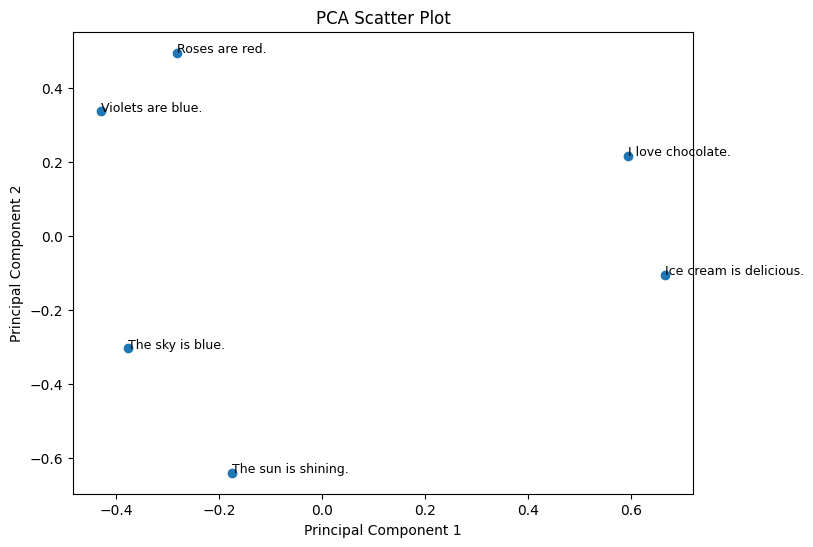

In [ ]:
import sys
import pandas as pd
import os

def create_pca_plot():
    """
    Reduces the dimensionality of text embeddings using PCA and visualizes them in a 2D scatter plot.

    Returns:
        df_reduced (DataFrame): DataFrame containing the reduced 2D coordinates and corresponding text labels.
    """
    # tag::calculate_embeddings_pca[]
    import os
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    from openai import OpenAI

    # Define text chunks
    text_chunks = [
        "The sky is blue.",
        "The sun is shining.",
        "I love chocolate.",
        "Ice cream is delicious.",
        "Roses are red.",
        "Violets are blue.",
    ]

    # Initialize OpenAI client
    client = OpenAI()  # uses the environment variable OPENAI_API_KEY
    embeddings = []

    # Generate embeddings for text chunks
    for text_chunk in text_chunks:
        response = client.embeddings.create(
            input=[text_chunk], model="text-embedding-3-small"
        )
        embedding = response.data[0].embedding
        embeddings.append(embedding)

    # Convert embeddings to a DataFrame
    embeddings_df = pd.DataFrame(
        embeddings, columns=[f"dim_{i}" for i in range(len(embeddings[0]))]
    )
    # end::calculate_embeddings_pca[]

    # tag::calculate_pca[]
    # Perform PCA with 2 components
    pca = PCA(n_components=2)
    df_reduced = pca.fit_transform(embeddings_df)

    # Create a new DataFrame with reduced dimensions
    df_reduced = pd.DataFrame(df_reduced, columns=["PC1", "PC2"])
    df_reduced["text"] = text_chunks  # Add original text chunks for labeling

    # Function to create a scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(df_reduced["PC1"], df_reduced["PC2"])

    # Add labels to each point
    for i, label in enumerate(df_reduced["text"]):
        plt.text(df_reduced["PC1"][i], df_reduced["PC2"][i], label, fontsize=9)

    # Add labels and title
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA Scatter Plot")

    # Save the plot
    plt.savefig("../results/principal_component_plot.svg", format="svg")
    # end::calculate_pca[]
    return plt, df_reduced

plt = create_pca_plot()


### How to calculate multimodal embeddings using CLIP

In [ ]:
def create_embeddings_using_clip():
    # tag::create_embeddings_using_clip[]
    import torch
    from PIL import Image
    from transformers import CLIPProcessor, CLIPModel

    # Load the model and processor
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    # Text and image inputs
    descriptions = ["A photo of a cat", "A photo of a dog"]
    images = [
        Image.open("../datasets/images/cat.jpg"),
        Image.open("../datasets/images/dog.jpg"),
    ]

    # Inference
    with torch.no_grad():
        inputs = processor(
            text=descriptions,
            images=images,
            return_tensors="pt",
            padding=True,
            truncation=True,
        )
        outputs = model(**inputs)

    dot_products_per_text = outputs.logits_per_text

    # Calculate probabilities
    probabilities = dot_products_per_text.softmax(dim=1)
    # end::create_embeddings_using_clip[]

    return probabilities, dot_products_per_text



In [ ]:
probabilities, dot_products_per_text = create_embeddings_using_clip()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
print(probabilities)

print("Probability that the first image is a cat:", probabilities[0][0].item())
print("Probability that the second image is a dog:", probabilities[1][1].item())

tensor([[9.9995e-01, 5.3789e-05],
        [1.2071e-01, 8.7929e-01]])
Probability that the first image is a cat: 0.9999462366104126
Probability that the second image is a dog: 0.8792922496795654


### How to use embeddings to train text classification models

In [ ]:
import sys
import pandas as pd
import os

def hybrid_search():
    """
    This function is used in chapter 3: Embeddings for the
    recipe hybrid search. It is combining keyword search using the
    BM25 algorithm and semantic search using embedding models and
    cosine similarity.
    """
    # bm25 keyword search algorithm
    # tag::hybrid_search_bm25[]
    from rank_bm25 import BM25Okapi

    text_chunks = [
        "The Great Fire of London in 1666 destroyed over 13,000 houses.",
        "Julius Caesar was assassinated on the Ides of March (March 15) in 44 BCE.",
        """The Black Death, is estimated to have killed nearly one-third of the European
        population""",
    ]
    tokenized_chunks = [chunk.split(" ") for chunk in text_chunks]

    bm25 = BM25Okapi(tokenized_chunks)

    users_query = "Tell me something interesting about diseases in history"
    tokenized_query = users_query.split(" ")

    doc_scores = bm25.get_scores(tokenized_query)

    ranking_keyword_search = (
        pd.DataFrame(doc_scores, columns=["scores"])
        .sort_values(by="scores", ascending=False)
        .index.to_list()
    )
    # end::hybrid_search_bm25[]

    # tag::hybrid_search_semantic_search[]
    from sentence_transformers.util import cos_sim

    embeddings_df = pd.DataFrame(text_chunks, columns=["text_chunk"])

    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
    embeddings = []

    def create_embeddings(text_chunk, client):
        embedding = (
            client.embeddings.create(input=[text_chunk], model="text-embedding-3-small")
            .data[0]
            .embedding
        )
        return embedding

    embeddings_df["embedding"] = embeddings_df["text_chunk"].apply(
        create_embeddings, client=client
    )

    users_question_embedding = create_embeddings(text_chunk=users_query, client=client)

    # Compute cosine_similarity between documents and query
    embeddings_df["similarity"] = cos_sim(
        embeddings_df["embedding"], users_question_embedding
    )

    ranking_semantic_search = embeddings_df.sort_values(
        by=["similarity"], ascending=False
    ).index
    # end::hybrid_search_semantic_search[]

    return ranking_semantic_search, ranking_keyword_search


In [ ]:
ranking_semantic_search, ranking_keyword_search = hybrid_search()

In [ ]:
ranking_semantic_search, ranking_keyword_search

(Index([2, 0, 1], dtype='int64'), [0, 1, 2])

In [ ]:
def calculate_hybrid_search_score(ranking_semantic_search, ranking_keyword_search):
    # tag::hybrid_search_combined_rating[]
    #  calculate a combined similarity score using Reciprocal Rank Fusion (RRF)
    combined_score = []

    for i in range(0, len(ranking_semantic_search), 1):
        k = 60
        rrf_score = 1 / (k + ranking_keyword_search[i]) + 1 / (
            k + ranking_semantic_search[i]
        )
        combined_score.append(rrf_score)

    combined_score_df = pd.DataFrame(combined_score, columns=["combined_score"])
    new_ranking = (
        combined_score_df.sort_values(by=["combined_score"], ascending=False).index + 1
    )

    # end::hybrid_search_combined_rating[]

    return new_ranking


In [ ]:
new_ranking = calculate_hybrid_search_score(
    ranking_semantic_search, ranking_keyword_search
)

In [ ]:
new_ranking

NameError: name 'new_ranking' is not defined

### How to optimize similarity search by combining similarity search and keyword search

In [ ]:
def hybrid_search():
    """
    This function is used in chapter 3: Embeddings for the
    recipe hybrid search. It is combining keyword search using the
    BM25 algorithm and semantic search using embedding models and
    cosine similarity.
    """
    # bm25 keyword search algorithm
    # tag::hybrid_search_bm25[]
    from rank_bm25 import BM25Okapi
    import pandas as pd
    import os

    text_chunks = [
        "The Great Fire of London in 1666 destroyed over 13,000 houses.",
        "Julius Caesar was assassinated on the Ides of March (March 15) in 44 BCE.",
        """The Black Death, is estimated to have killed nearly one-third of the European
        population""",
    ]
    tokenized_chunks = [chunk.split(" ") for chunk in text_chunks]

    bm25 = BM25Okapi(tokenized_chunks)

    users_query = "Tell me something interesting about diseases in history"
    tokenized_query = users_query.split(" ")

    doc_scores = bm25.get_scores(tokenized_query)

    ranking_keyword_search = (
        pd.DataFrame(doc_scores, columns=["scores"])
        .sort_values(by="scores", ascending=False)
        .index.to_list()
    )
    # end::hybrid_search_bm25[]

    # tag::hybrid_search_semantic_search[]
    from sentence_transformers.util import cos_sim

    embeddings_df = pd.DataFrame(text_chunks, columns=["text_chunk"])

    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
    embeddings = []

    def create_embeddings(text_chunk, client):
        embedding = (
            client.embeddings.create(input=[text_chunk], model="text-embedding-3-small")
            .data[0]
            .embedding
        )
        return embedding

    embeddings_df["embedding"] = embeddings_df["text_chunk"].apply(
        create_embeddings, client=client
    )

    users_question_embedding = create_embeddings(text_chunk=users_query, client=client)

    # Compute cosine_similarity between documents and query
    embeddings_df["similarity"] = cos_sim(
        embeddings_df["embedding"], users_question_embedding
    )

    ranking_semantic_search = embeddings_df.sort_values(
        by=["similarity"], ascending=False
    ).index
    # end::hybrid_search_semantic_search[]

    return ranking_semantic_search, ranking_keyword_search


In [ ]:
ranking_semantic_search, ranking_keyword_search = hybrid_search()

In [ ]:
ranking_semantic_search, ranking_keyword_search

In [ ]:

def calculate_hybrid_search_score(ranking_semantic_search, ranking_keyword_search):
    # tag::hybrid_search_combined_rating[]
    #  calculate a combined similarity score using Reciprocal Rank Fusion (RRF)
    combined_score = []

    for i in range(0, len(ranking_semantic_search), 1):
        k = 60
        rrf_score = 1 / (k + ranking_keyword_search[i]) + 1 / (
            k + ranking_semantic_search[i]
        )
        combined_score.append(rrf_score)

    combined_score_df = pd.DataFrame(combined_score, columns=["combined_score"])
    new_ranking = (
        combined_score_df.sort_values(by=["combined_score"], ascending=False).index + 1
    )

    # end::hybrid_search_combined_rating[]

    return new_ranking


In [ ]:
calculate_hybrid_search_score(
    ranking_semantic_search, ranking_keyword_search
)

In [ ]:
calculate_hybrid_search_score

### Performing Text Classification Using Embeddings

In [ ]:
chunks_df

,text,label,embedding
0,The\n \nHistory\n \nof\n \nDeep\n \nLearning\n...,Deep_Learning,"[0.01142459362745285, -0.06355778127908707, 0...."
1,learn\n \nfrom\n \nvast\n \namounts\n \nof\n \...,Deep_Learning,"[0.04786442220211029, -0.023677771911025047, 0..."
2,practical\n \napplications.\n \nThis\n \nartic...,Deep_Learning,"[-0.006355909164994955, -0.03264368325471878, ..."
3,industries.\n \nEarly\n \nFoundations\n \n(194...,Deep_Learning,"[-0.017487941309809685, -0.051235076040029526,..."
4,McCulloch\n \nand\n \nWalter\n \nPitts\n \npro...,Deep_Learning,"[0.011484782211482525, -0.04983634874224663, -..."
...,...,...,...
84,initiatives.\n \nClubs\n \nare\n \nalso\n \nfo...,Premier_League,"[0.010999810881912708, 0.029332827776670456, 0..."
85,From\n \nits\n \nhumble\n \nbeginnings\n \nin\...,Premier_League,"[0.024797702208161354, -0.024624811485409737, ..."
86,"its\n \nmix\n \nof\n \nhistory,\n \ncompetitio...",Premier_League,"[0.03827759623527527, -0.04071657359600067, 0...."
87,game.\n \nAs\n \nit\n \nadapts\n \nto\n \nmode...,Premier_League,"[0.03319929912686348, -0.004885807633399963, 0..."


In [ ]:

def building_a_classification_model_using_embeddings(chunks_df):
    from openai import OpenAI
    import os
    import pandas as pd
    def create_embeddings(text_chunk, client):
        embedding = (
            client.embeddings.create(input=[text_chunk], model="text-embedding-3-small")
            .data[0]
            .embedding
        )
        return embedding

    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

    # tag::building_a_classification_model_using_embeddings[]
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.datasets import make_classification

    y = chunks_df["label"]
    X = chunks_df["embedding"].apply(
        lambda x: pd.Series(eval(x)) if isinstance(x, str) else pd.Series(x)
    )

    # Train a random forest classifier
    clf = RandomForestClassifier()
    clf.fit(X, y)

    # end::building_a_classification_model_using_embeddings[]

    # tag::classification_model_predict_probability[]
    # Predict probabilities
    test_embedding = create_embeddings(
        text_chunk="What is the name of the top football league in England?",
        client=client,
    )

    X_test = [test_embedding]

    # Predict the most likely class
    predicted_classes = clf.predict(X_test)  # e.g. ['Premier_League']
    probabilities = clf.predict_proba(X_test)  # e.g. array([[0.06, 0.94]])
    # end::classification_model_predict_probability[]

    return predicted_classes, probabilities


In [ ]:
predicted_classes, probabilities = building_a_classification_model_using_embeddings(chunks_df)

In [ ]:
predicted_classes, probabilities

(array(['Premier_League'], dtype=object), array([[0.13, 0.87]]))